<a href="https://colab.research.google.com/github/Arash444/Foundation-of-Machine-Learning/blob/main/Fall2025_HW3_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS224-EE242a - Fall 2025 - Homework 3

# Due: Friday, October 24, 2025 @ 11:59pm

### Maximum points: 50 pts


## Submit your solution to Gradescope:
1. Submit a single PDF to **HW3**
2. Submit your jupyter notebook to **HW3-code**

**Notice:**
In Markdown, when you write in LaTeX math mode, do not leave any leading and trailing whitespaces inside the dollar signs ($). For example, write `(dollarSign)\mathbf(dollarSign)(dollarSign)` instead of `(dollarSign)(space)\mathbf{w}(dollarSign)`. Otherwise, nbconvert will throw an error and the generated pdf will be incomplete. [This is a bug of nbconvert.](https://tex.stackexchange.com/questions/367176/jupyter-notebook-latex-conversion-fails-escaped-and-other-symbols)

**See the additional submission instructions at the end of this notebook**


## <font color='green'> Enter your information below: </font>

### <font color='green'> Your Name (submitter): Arash Shahin</font>

### <font color='green'> Your student ID (submitter): 862622048</font>
    
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>


## Academic Integrity
Each assignment should be done  individually. You may discuss general approaches with other students in the class, and ask questions to the TAs, but  you must only submit work that is yours . If you receive help by any external sources (other than the TA and the instructor), you must properly credit those sources, and if the help is significant, the appropriate grade reduction will be applied. If you fail to do so, the instructor and the TAs are obligated to take the appropriate actions outlined at http://conduct.ucr.edu/policies/academicintegrity.html . Please read carefully the UCR academic integrity policies included in the link.


In [ ]:
# Standard library imports.
import random as rand

# Related third party imports.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Local application/library specific imports.
# import here if you write .py script

### Question 1. Logistic regression [50 pts]

In this question, we will plot the logistic function and perform logistic regression. We will use the breast cancer data set.  This data set is described here:

https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin

Each sample is a collection of features that were manually recorded by a physician upon inspecting a sample of cells from fine needle aspiration.  The goal is to detect if the cells are benign or malignant.  

We could use the `sklearn` built-in `LogisticRegression` class to find the weights for the logistic regression problem.  The `fit` routine in that class has an *optimizer* to select the weights to best match the data.  To understand how that optimizer works, in this problem, we will build a very simple gradient descent optimizer from scratch.  

### Loading and visualizing the Breast Cancer Data

We load the data from the UCI site and remove the missing values.

In [ ]:
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names,na_values='?',header=None)
df = df.dropna()
df.head(6)

,id,thick,size_unif,shape_unif,marg,cell_size,bare,chrom,normal,mit,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2
5,1017122,8,10,10,8,7,10.0,9,7,1,4


After loading the data, we can create a scatter plot of the data labeling the class values with different colors.  We will pick two of the features.  

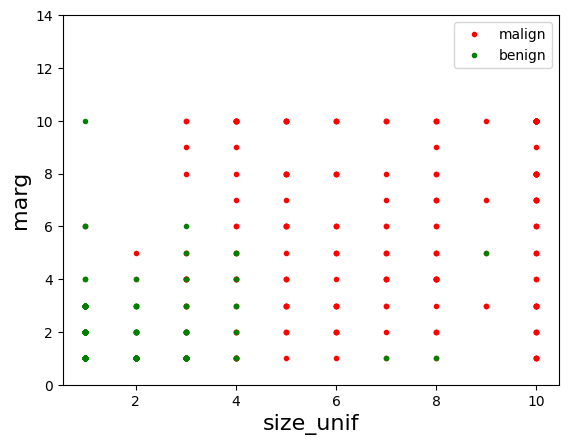

In [ ]:
# Get the response.  Convert to a zero-one indicator
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int)
Iben = (y==0)
Imal = (y==1)

# Get two predictors
xnames =['size_unif','marg']
X = np.array(df[xnames])

# Create the scatter plot
plt.plot(X[Imal,0],X[Imal,1],'r.')
plt.plot(X[Iben,0],X[Iben,1],'g.')
plt.xlabel(xnames[0], fontsize=16)
plt.ylabel(xnames[1], fontsize=16)
plt.ylim(0,14)
plt.legend(['malign','benign'],loc='upper right')

The above plot is not informative, since many of the points are on top of one another.  Thus, we cannot see the relative frequency of points.  

### Logistic function

We will build a binary classifier using *logistic regression*.  In logistic regression, we do not just output an estimate of the class label.  Instead, we ouput a *probability*, an estimate of how likely the sample is one class or the other.  That is our output is a number from 0 to 1 representing the likelihood:
$$
    P(y = 1|x)
$$
which is our estimate of the probability that the sample is one class (in this case, a malignant sample) based on the features in `x`.  This is sometimes called a *soft classifier*.  

In logistic regression, we assume that likelihood is of the form
$$
    P(y=1|x) = \sigma(z),  \quad z = w(1)x(1) + \cdots + w(d)x(d) + b = \mathbf{w}^T\mathbf{x}+b,  
$$
where $w(1),\ldots,w(d),b$ are the classifier weights and $\sigma(z)$ is the so-called *logistic* function:
$$
    \sigma(z) = \frac{1}{1+e^{-z}}.
$$

To understand the logistic function, suppose $x$ is a scalar and samples $y$ are drawn with $P(y=1|x) = f(w x+b)$ for some $w$ and $b$.  We plot these samples for different $w,b$.

/tmp/ipython-input-384680072.py:21: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,yp,c=yp,edgecolors='none',marker='+')


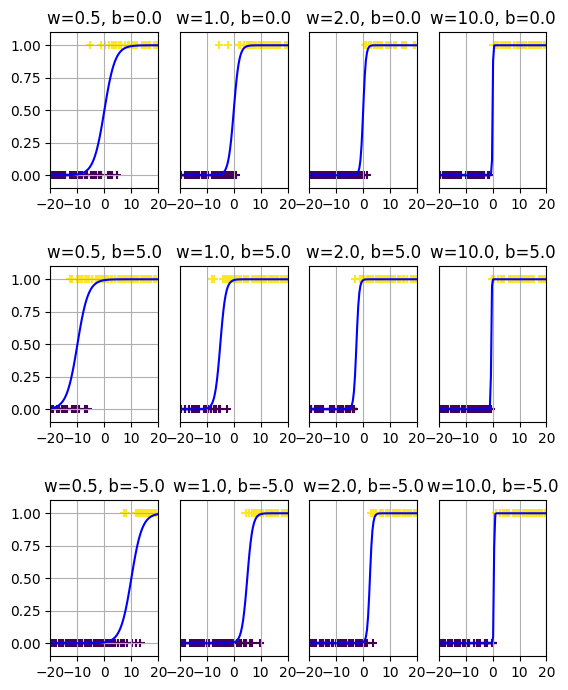

In [ ]:
N = 100
xm = 20
ws = np.array([0.5,1,2,10])
bs = np.array([0, 5, -5])
wplot = ws.size
bplot = bs.size
iplot = 0
for b in bs:
  for w in ws:
    iplot += 1
    x  = np.random.uniform(-xm,xm,N)

    py = 1/(1+np.exp(-w*x-b))

    yp = np.array(np.random.rand(N) < py) # hard label for random points
    xp = np.linspace(-xm,xm,100)
    pyp = 1/(1+np.exp(-w*xp-b)) # soft label (probability) for the points

    plt.subplot(bplot,wplot,iplot)

    plt.scatter(x,yp,c=yp,edgecolors='none',marker='+')
    plt.plot(xp,pyp,'b-')
    plt.axis([-xm,xm,-0.1,1.1])
    plt.grid()
    if ((iplot%4)!=1):
        plt.yticks([])
    plt.xticks([-20,-10,0,10,20])
    plt.title('w={0:.1f}, b={1:.1f}'.format(w,b))

    plt.subplots_adjust(top=1.5, bottom=0.2, hspace=0.5, wspace=0.2)

We see that $\sigma(wx+b)$ represents the probability that $y=1$.  The function $\sigma(wx) > 0.5$ for $x>0$ meaning the samples are more likely to be $y=1$.  Similarly, for $x<0$, the samples are more likely to be $y=0$.  The scaling $w$ determines how fast that transition is and $b$ influences the transition point.  

### Question 1a: Fitting the Logistic Model on Two Variables using Library Implementation [10 pts]

We will fit the logistic model on the two variables `size_unif` and `marg` that we were looking at earlier.

Follow the instructions on the cell to complete the code.

In [ ]:
# Create a list named xnames that contains 2 elements: 'size_unif' and 'marg'
xnames = ['size_unif', 'marg']

# Take the two columns from the data stored in df variable and convert it to numpy array. Store the result in variable X.
X = np.array(df[xnames])
ones = np.ones((X.shape[0], 1))
X = np.hstack((ones, X))

# Print the shape of variable X
print(X.shape[0])

683


Next we split the data into training and test

In [ ]:
# Split into training and test
from sklearn.model_selection import train_test_split

# Split the data into train and test set using the train_test_split function setting test_size=0.30
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.3, random_state=4)

**Logistic regression in scikit-learn**

The actual fitting is easy with the `sklearn` package.  The parameter `C`
states the level of inverse regularization strength with higher values meaning less regularization. Right now, we will select a high value to minimally regularize the estimate.

We can also measure the accuracy on the test data. You should get an accuracy around 90%.

Follow the instructions on the cell to complete the code.

In [ ]:
from sklearn import datasets, linear_model, preprocessing

# Create the Logistic Regression model using the library class linear_model.LogisticRegression setting C to 1e5
reg = linear_model.LogisticRegression(C=1e5)

# Fit the training data to the model calling the fit() funtion
reg.fit(Xtr, ytr)

# Print the coefficients and intercept of the decision function learnt. They are stored in coef_ and intercept_ attributes of the model
print(reg.coef_)
print(reg.intercept_)

# Generate the prediction on the test set by calling the predict() function
Yhat = reg.predict(Xts)

# Calculate the mean accuracy and print it like "Accuracy on test data = 0.xxxxxx"
acc = reg.score(Xts, yts)
print("Accuracy on test data = %.6f" % acc)

[[-3.12189745  1.717051    0.39065305]]
[-3.12190383]
Accuracy on test data = 0.936585


**Now, we will implement the regression function using gradient descent.**

### Question 1b. Gradient descent for logistic regression [20 pts]
In the class we saw that the weight vector can be found by minimizing the negative log likelihood over $N$ training samples.  The negative log likelihood is called the *loss* function.  For the logistic regression problem, the loss function simplifies to

$$L(\mathbf{w}) = - \sum_{i=1}^N y_i \log \sigma(\mathbf{w}^T\mathbf{x}_i+b) + (1-y_i)\log [1-\sigma(\mathbf{w}^T\mathbf{x}_i+b)].$$

Gradient can be computed as $$\nabla_\mathbf{w}L = \sum_{i=1}^N(\sigma(\mathbf{w}^T\mathbf{x}_i + b)-y_i)\mathbf{x}_i ,~~~ \nabla_b L = \sum_{i=1}^N(\sigma(\mathbf{w}^T\mathbf{x}_i + b)-y_i).$$


We can update $\mathbf{w},b$ at every iteration as  
$$ \mathbf{w} \gets \mathbf{w} - \alpha \nabla_\mathbf{w}L, \\ b \gets b - \alpha \nabla_b L.$$

**Note that we could also append the constant term in $\mathbf{w}$ and append 1 to every $\mathbf{x}_i$ accordingly, but we kept them separate in the expressions above.**



**Gradient descent function implementation**

We will use this loss function and gradient to implement a gradient descent-based method for logistic regression.

Recall that training a logistic function means finding a weight vector `w` for the classification rule:

    P(y=1|x,w) = 1/(1+\exp(-z)), z = w[0]+w[1]*x[1] + ... + w[d]x[d]
    
The function implemented should follow the following format:
```python
def logistic_regression_gd(X,y,learning_rate = 0.001,max_iter=1000,tol=pow(10,-5)):
```
Where `X` is the training data feature(s), `y` is the variable to be predicted, `learning_rate` is the learning rate used ($\alpha$ in the slides), `max_iter` defines the maximum number of iterations that gradient descent is allowed to run, and `tol` is defining the tolerance for convergence (which we'll discuss next).

The return values for the above function should be
1. `w` which are the regression parameters,
2. `all_cost` which is an array where each position contains the value of the objective function $L(\mathbf{w})$ for a given iteration,
3. `iters` which counts how many iterations did the algorithm need in order to converge to a solution.

Gradient descent is an iterative algorithm; it keeps updating the variables until a convergence criterion is met. In our case, our convergence criterion is whichever of the following two criteria happens first:

- The maximum number of iterations is met
- The relative improvement in the cost is not greater than the tolerance we have specified. For this criterion, you may use the following snippet into your code:
```python
np.absolute(all_cost[it] - all_cost[it-1])/all_cost[it-1] <= tol
```

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X,w,y):
    h = sigmoid(X @ w)

    term1 = y * np.log(h)
    term2 = (1 - y) * np.log(1 - h)
    L = -np.sum(term1 + term2)

    return L

def logistic_regression_gd(X,y,learning_rate = 0.00001,max_iter=1000,tol=pow(10,-5)):
    num_features = X.shape[1]
    w = np.zeros(num_features)
    all_cost = []

    for iters in range(max_iter):
        h = sigmoid(X @ w)
        gradient = X.T @ (h - y)
        w = w - (learning_rate * gradient)
        current_cost = compute_cost(X, w, y)
        all_cost.append(current_cost)
        if iters > 0:
            relative_improvement = np.absolute(all_cost[iters] - all_cost[iters-1]) / all_cost[iters-1]
            if relative_improvement <= tol:
                break

    return w, all_cost, iters + 1

### Question 1c: Convergence plots and test accuracy [10 pts]

After implementing gradient descent for logistic regression, we would like to test that indeed our algorithm converges to a solution. In order see this, we are going to look at the value of the objective/loss function $L(\mathbf{w})$ as a function of the number of iterations, and ideally, what we would like to see is $L(\mathbf{w})$ drops as we run more iterations, and eventually it stabilizes.

The learning rate plays a big role in how fast our algorithm converges: a larger learning rate means that the algorithm is making faster strides to the solution, whereas a smaller learning rate implies slower steps. In this question we are going to test two different values for the learning rate:
- 0.001
- 0.00001

while keeping the default values for the max number of iterations and the tolerance.


- **Plot the two convergence plots (cost vs. iterations)**
- **Calculate the accuracy of classifier on the test data `Xts`**
- **What do you observe?**


**Calculate accuracy of your classifier on test data**

To calculate the accuracy of our classifier on the test data, we can create a predict method.

Implement a function `predict(X,w)` that provides you label 1 if $\mathbf{w}^T\mathbf{x} + b > 0$ and 0 otherwise.  

In [ ]:
def predict(X,w):
    z = X @ w
    yhat = np.where(z > 0, 1, 0)
    return yhat

Convergence: Learning Rate 0.00001
Test accuracy = 0.917073
Convergence: Learning Rate 0.001
Test accuracy = 0.936585
[-5.95135842  1.63046166  0.37229028]


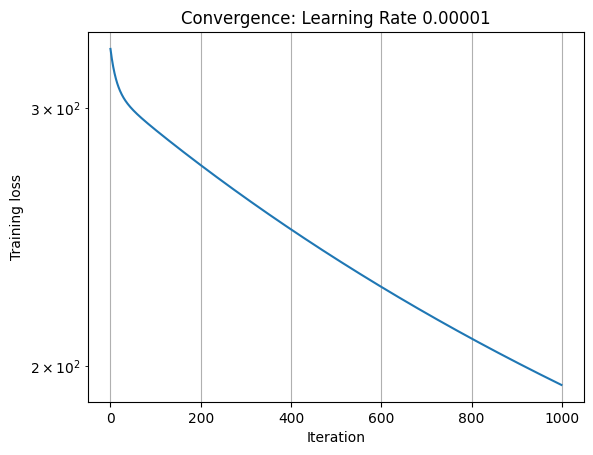

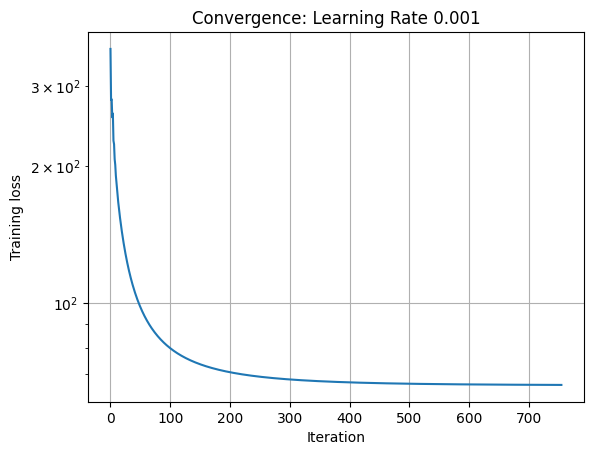

In [ ]:
# test gradient descent with step size 0.001
# test gradient descent with step size 0.00001


(w, all_cost,iters) = logistic_regression_gd(Xtr,ytr,learning_rate = 0.00001,max_iter = 1000, tol=pow(10,-5))
plt.figure()
plt.semilogy(all_cost[0:iters])
plt.grid(True)
plt.title('Convergence: Learning Rate 0.00001')
plt.xlabel('Iteration')
plt.ylabel('Training loss')

yhat = predict(Xts,w)
acc = np.mean(yhat == yts)
print('Convergence: Learning Rate 0.00001')
print("Test accuracy = %f" % acc)

(w, all_cost,iters) = logistic_regression_gd(Xtr,ytr,learning_rate = 0.001,max_iter = 1000, tol=pow(10,-5))
plt.figure()
plt.semilogy(all_cost[0:iters])
plt.grid(True)
plt.title('Convergence: Learning Rate 0.001')
plt.xlabel('Iteration')
plt.ylabel('Training loss')

yhat = predict(Xts,w)
acc = np.mean(yhat == yts)
print('Convergence: Learning Rate 0.001')
print("Test accuracy = %f" % acc)

print(w)


<font color="green">Observations: </font>

1.   In these two cases, the higher learning rate led to a significantly quicker reduction in training loss. The higher rate run met the convergence criterion and stopped earlier, while the lower rate run failed to meet the criterion and ran for the maximum number of iterations, resulting in a much higher final loss.

2. We observe that with each iteration in both graphs, we reduce the training loss from its very high initial start. In early iterations, the reduction of training loss is faster, while near the end the reduction rate slows down.

3.   The run with the larger learning rate resulted in a higher accuracy rate because it successfully converged closer to the optimal solution. It led to a 2% higher test accuracy than the run with the slower learning rate, which had not yet converged when we reached the max number of iterations.

4. We did not see divergences in either of them, meaning that neither of the learning rates were too large.


### Question 1d: Print the misclassified data from the test set [10 pts]

As the accuracy is less than 100%, some data are misclassified. Print the misclassified data in the following format:

`
Input data: [a b] Original label: 1 Predicted label: 0
`

In [ ]:
misclassified_mask = (Yhat != yts).flatten()

misclassified_X = Xts[misclassified_mask, 1:]
misclassified_y_original = yts[misclassified_mask]
misclassified_y_predicted = Yhat[misclassified_mask]

for i in range(len(misclassified_X)):
    input_data_str = ' '.join([f"{x:.2f}" for x in misclassified_X[i]])

    original_label = misclassified_y_original[i]
    predicted_label = misclassified_y_predicted[i]

    print(f"Input data: [{input_data_str}] Original label: {original_label} Predicted label: {predicted_label}")

Input data: [3.00 1.00] Original label: 1 Predicted label: 0
Input data: [4.00 3.00] Original label: 0 Predicted label: 1
Input data: [9.00 5.00] Original label: 0 Predicted label: 1
Input data: [4.00 1.00] Original label: 0 Predicted label: 1
Input data: [7.00 1.00] Original label: 0 Predicted label: 1
Input data: [3.00 1.00] Original label: 1 Predicted label: 0
Input data: [4.00 4.00] Original label: 0 Predicted label: 1
Input data: [3.00 1.00] Original label: 1 Predicted label: 0
Input data: [8.00 1.00] Original label: 0 Predicted label: 1
Input data: [4.00 3.00] Original label: 0 Predicted label: 1
Input data: [2.00 1.00] Original label: 1 Predicted label: 0
Input data: [3.00 3.00] Original label: 0 Predicted label: 1
Input data: [1.00 3.00] Original label: 1 Predicted label: 0


- Which class is showing more misclassifications?
* <font color="green">**Answer:** </font>

Class 0: 8 missclassified as 1

Class 1: 5 missclassified as 0

So class 0 has been more missclassified


---

## <font color='red'> **Submission instructions** </font>
1. Follow these steps to download this Colab notebook and convert it to PDF. You can follow similar steps as [here](https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab) but convert to PDF (not HTML).
 - Download your notebook as `.ipynb` file. You can do it using only Google Colab. `File` -> `Download` -> `Download .ipynb`.
 - Reupload it so Colab can see it. Click on the `Files` icon on the far left to expand the side bar. You can directly drag the downloaded `.ipynb` file to the area. Or click `Upload to session storage` icon and then select & upload your `.ipynb` file.
 - Use the following commands to convert it to PDF.
 ```
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc
!pip install pypandoc
!jupyter nbconvert --log-level CRITICAL --to pdf /path/to/Fall2025_HW3-Logistic-Regression.ipynb
  ```
 - Your PDF file is ready. Click 3 dots and `Download`.

<font color='red'> **Note: Please follow these instructions to generate the PDF. DO NOT use any other method, such as `ctrl+p`.** </font>

2. Upload the PDF to Gradescope and **select** the correct pages for each question. Refer to the shared video or contact the TAs if you face any issues. **Important!**


3. Upload the `.ipynb` file to Gradescope. Make sure that both the **code** and the **PDF** are uploaded. **Important!**


Notice: In case of errors in conversion, please check your LaTeX and debug. In Markdown, when you write in LaTeX math mode, do not leave any leading and trailing whitespaces inside the dollar signs ($). For example, write `(dollarSign)\mathbf(dollarSign)(dollarSign)` instead of `(dollarSign)(space)\mathbf{w}(dollarSign)`. Otherwise, nbconvert will throw an error and the generated pdf will be incomplete.

In [ ]:
!sudo apt-get update
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc
!pip install pypandoc

In [ ]:
!jupyter nbconvert --log-level INFO --to pdf /content/Fall2025_HW3_Logistic_Regression.ipynb # make sure the ipynb name is correct

[NbConvertApp] Converting notebook /content/Fall2025_HW3_Logistic_Regression.ipynb to pdf
[NbConvertApp] Support files will be in Fall2025_HW3_Logistic_Regression_files/
[NbConvertApp] Making directory ./Fall2025_HW3_Logistic_Regression_files
[NbConvertApp] Writing 63602 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 206145 bytes to /content/Fall2025_HW3_Logistic_Regression.pdf
